In [1]:
! pip install -q "diffusers==0.30.3"

In [2]:
from diffusers import DiffusionPipeline
import torch
from diffusers import DPMSolverMultistepScheduler

In [3]:
model_id = "runwayml/stable-diffusion-v1-5"
pipeline = DiffusionPipeline.from_pretrained(model_id, use_safetensors=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
prompt = "portrait photo of the traditional farmer"

In [5]:
pipeline = pipeline.to("cuda")

In [6]:
generator = torch.Generator("cuda").manual_seed(0)

  0%|          | 0/50 [00:00<?, ?it/s]

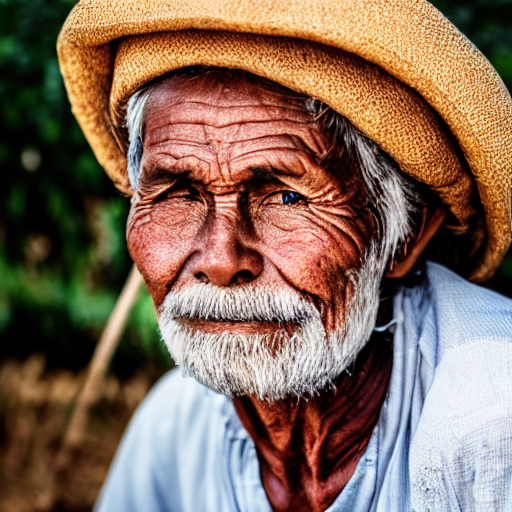

In [7]:
image = pipeline(prompt, generator=generator).images[0]
image

inference time - 23 Secs

###### running **float16** precision

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

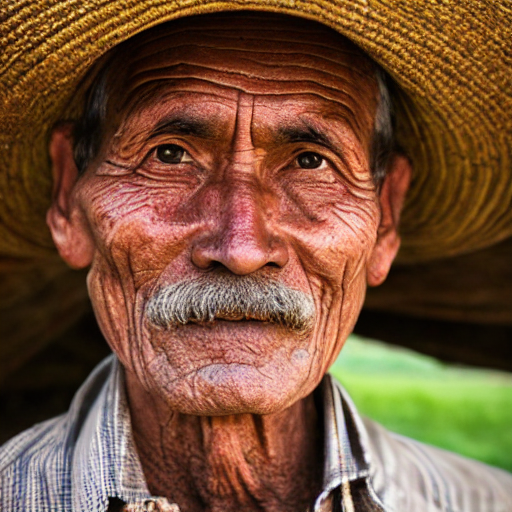

In [9]:
# By default, DiffusionPipeline consits of 50 inference_steps and PNDMScheduler

pipeline = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True)
pipeline = pipeline.to("cuda")
generator = torch.Generator("cuda").manual_seed(1)
image = pipeline(prompt, generator=generator).images[0]
image

inference time - 7 Secs

In [11]:
# find compatible  scheduler
pipeline.scheduler.compatibles

[diffusers.schedulers.scheduling_ddim.DDIMScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2DiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.utils.dummy_torch_and_torchsde_objects.DPMSolverSDEScheduler,
 diffusers.schedulers.scheduling_edm_euler.EDMEulerScheduler,
 diffusers.schedulers.scheduling_ddpm.DDPMScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepSchedul

###### reduce **num_inference_step**s with suitable scheduler

In [10]:
# config with compatibles scheduler
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)

  0%|          | 0/20 [00:00<?, ?it/s]

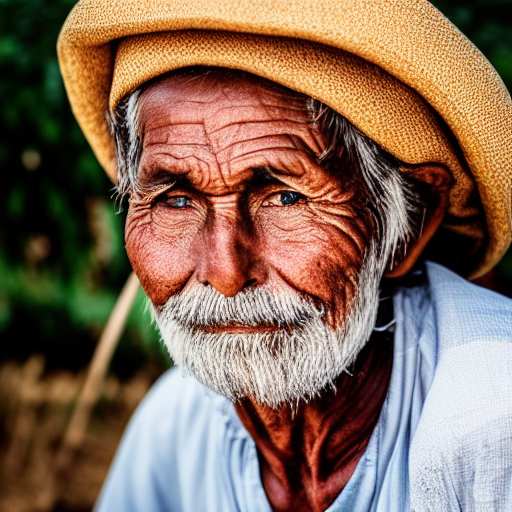

In [11]:
generator = torch.Generator("cuda").manual_seed(0)
image = pipeline(prompt, generator=generator, num_inference_steps=20).images[0]
image

inference time - 2 Secs

# Less Memory

Use batch size

In [12]:
def get_inputs(batch_size=1):
    generator = [torch.Generator("cuda").manual_seed(i) for i in range(batch_size)]
    prompts = batch_size * [prompt]
    num_inference_steps = 20

    return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

  0%|          | 0/20 [00:00<?, ?it/s]

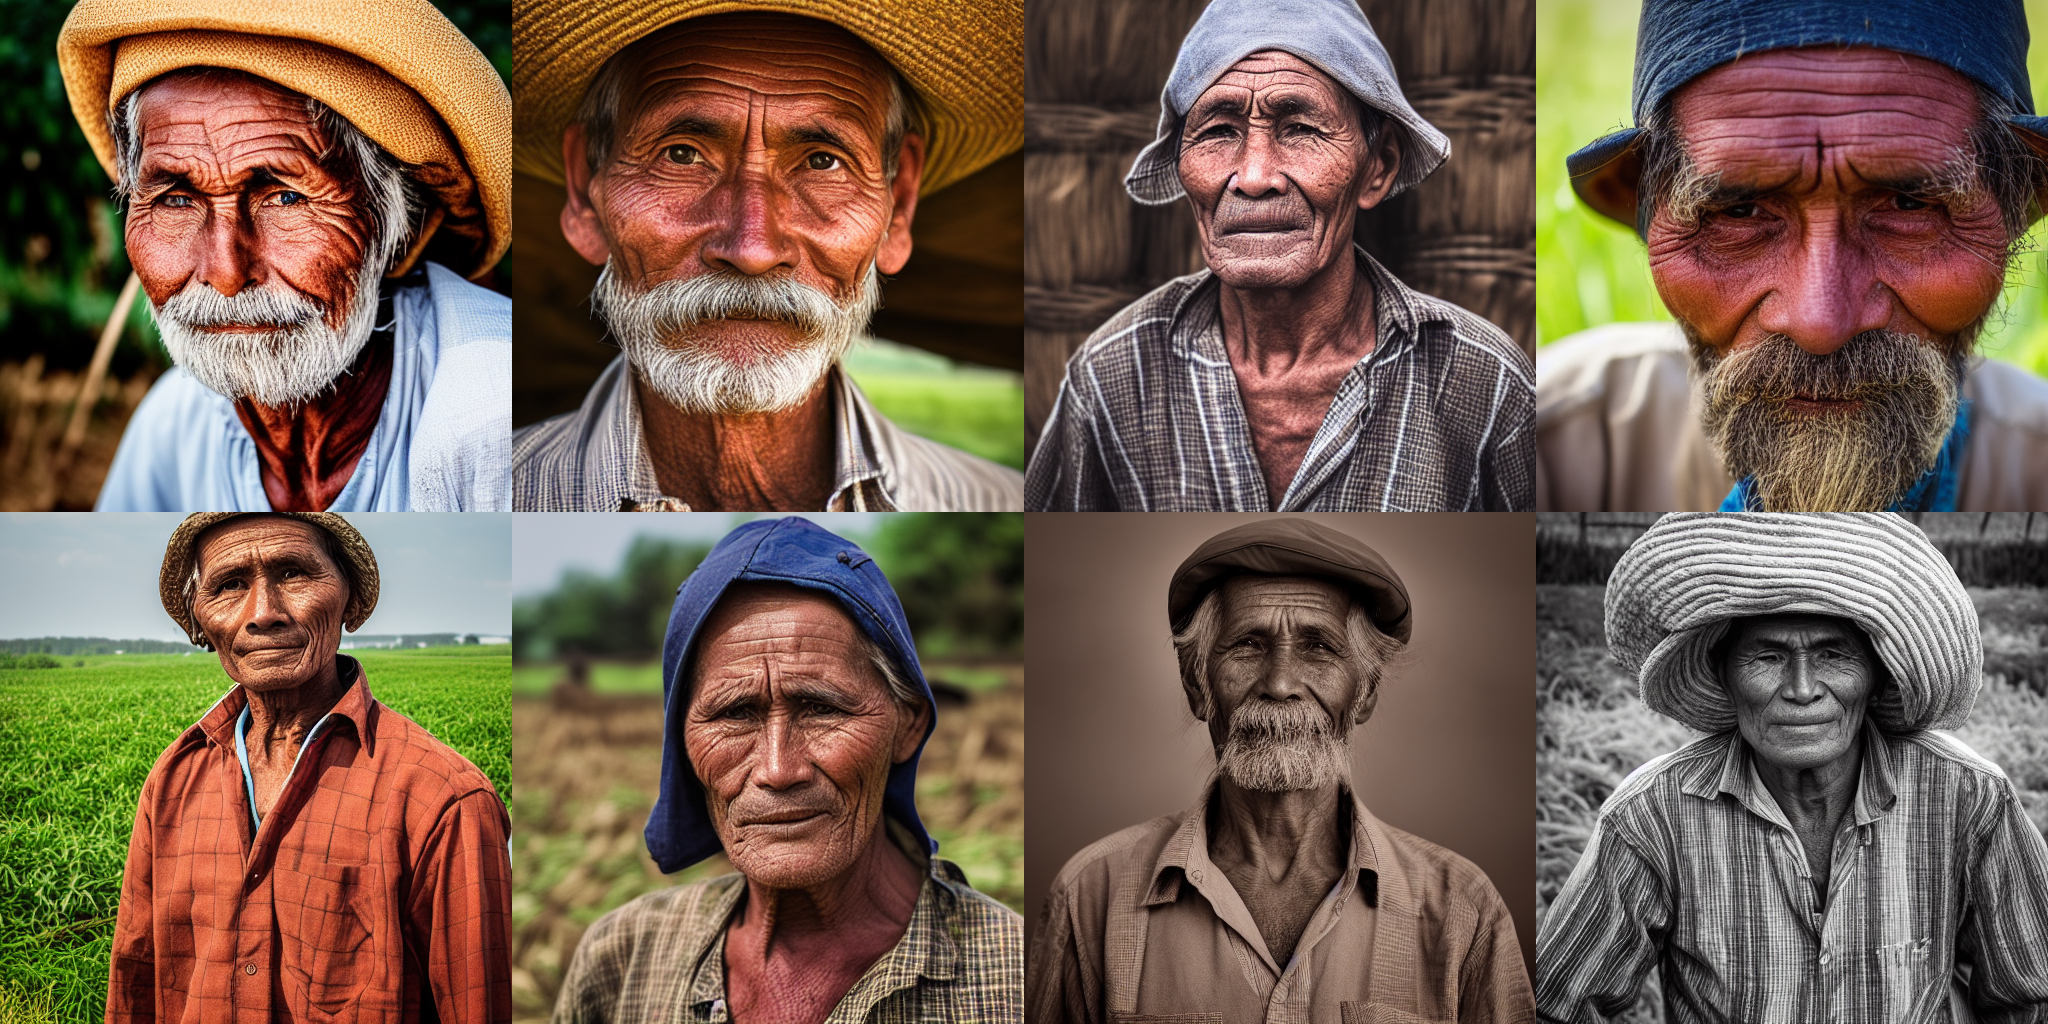

In [14]:
from diffusers.utils import make_image_grid

images = pipeline(**get_inputs(batch_size=8)).images
make_image_grid(images, 2, 4)

inference time for 8 images- 19 Secs